<a href="https://colab.research.google.com/github/kojikojiprg/kaggle/blob/master/titanic_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colabでkaggle.jsonをアップロード
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kojikojipro","key":"04c6e3329de941099c00e7a9a89a384a"}'}

In [0]:
# Google Colabでkaggle.jsonをフォルダ移動
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Google Colabでデータセットをダウンロード
!pip install kaggle
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 23.7MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 30.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.75MB/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# テストデータの'PassengerId'を取得しておく
passenger_id = test.loc[:, 'PassengerId']

# 表示
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Nullデータの確認
print(pd.isnull(train).sum())
print(pd.isnull(test).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [0]:
# 性別を数値に置き換える
func = lambda x: 0 if x == 'male' else 1
train['Sex'] = train['Sex'].map(func)
test['Sex'] = test['Sex'].map(func)

In [0]:
# CabinのデータはNanを0、それ以外を1に置き換える
func = lambda x: 0 if pd.isnull(x) else 1
train['CabinBool'] = train['Cabin'].map(func)
test['CabinBool'] = test['Cabin'].map(func)

In [0]:
# FareのテストデータにNullがあるので、トレインデータの中央値を入れる
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

# 5段階で分割する
fare = (max(train['Fare']) - min(train['Fare'])) / 5
func = lambda x: int(x / fare)
train['FareGroup'] = train['Fare'].map(func)
test['FareGroup'] = test['Fare'].map(func)

In [0]:
# Embarkedのnullのデータは一番頻度の高いものに置き換える
embarked_list = ['S', 'C', 'Q']
max_count = 0
max_index = 0
for i, embarked in enumerate(embarked_list):
    now_count = (train['Embarked'] == embarked).sum()
    if max_count < now_count:
        max_index = i

train['Embarked'] = train['Embarked'].fillna(embarked_list[max_index])

# 数字に置き換える
_, uniques = pd.factorize(train['Embarked'])
convertor = {key: value for value, key in enumerate(uniques)}
func = lambda x: convertor[x]
train['Embarked'] = train['Embarked'].map(func)
test['Embarked'] = test['Embarked'].map(func)

In [0]:
# 年齢のNullのデータに-1を代入する
train['Age'] = train['Age'].fillna(-1)
test['Age'] = test['Age'].fillna(-1)

# 10歳毎に分割する
func = lambda x: int(x / 10) if x >= 0 else -1
train['AgeGroup'] = train['Age'].map(func)
test['AgeGroup'] = test['Age'].map(func)

In [9]:
del_cols = ['PassengerId', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin']
ans_col = ['Survived']

# トレーニングデータを分割
train_x = train.drop(del_cols + ans_col, axis=1)
train_y = train.loc[:, ans_col]

# テストデータの必要のないカラムを削除
test_x = test.drop(del_cols, axis=1)

# One Hot Encoding
train_x = pd.get_dummies(train_x, columns=train_x.columns)
train_y = pd.get_dummies(train_y, columns=ans_col)
test_x = pd.get_dummies(test_x, columns=test_x.columns)

train_x

,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_0,Embarked_1,Embarked_2,CabinBool_0,CabinBool_1,FareGroup_0,FareGroup_1,FareGroup_2,FareGroup_5,AgeGroup_-1,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,AgeGroup_6,AgeGroup_7,AgeGroup_8
0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
887,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
888,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
889,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
input_size = len(train_x.columns)
outpu_size = len(train_y.columns)

train_x = torch.FloatTensor(np.array(train_x)).to(device)
train_y = torch.FloatTensor(np.array(train_y)).to(device)

test_x = torch.FloatTensor(np.array(test_x)).to(device)

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

        self.do1 = nn.Dropout2d(0.2)
        self.do2 = nn.Dropout2d(0.2)
        self.do3 = nn.Dropout2d(0.2)
        self.do4 = nn.Dropout2d(0.2)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = self.do1(x)
        x = f.relu(self.fc2(x))
        x = self.do2(x)
        x = f.relu(self.fc3(x))
        x = self.do3(x)
        x = f.relu(self.fc4(x))
        x = self.do4(x)
        x = self.fc5(x)
        return x

In [20]:
HIDDEN_SIZE = 100
EPOCH_NUM = 500
BATCH_SIZE = 10

train_dataset = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = Net(input_size, HIDDEN_SIZE, outpu_size).to(device)
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=38, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=2, bias=True)
  (do1): Dropout2d(p=0.2, inplace=False)
  (do2): Dropout2d(p=0.2, inplace=False)
  (do3): Dropout2d(p=0.2, inplace=False)
  (do4): Dropout2d(p=0.2, inplace=False)
)


Epoch: 50 | Avearage Loss: 1
Epoch: 100 | Avearage Loss: 1
Epoch: 150 | Avearage Loss: 1
Epoch: 200 | Avearage Loss: 1
Epoch: 250 | Avearage Loss: 0
Epoch: 300 | Avearage Loss: 0
Epoch: 350 | Avearage Loss: 0
Epoch: 400 | Avearage Loss: 0
Epoch: 450 | Avearage Loss: 0
Epoch: 500 | Avearage Loss: 0


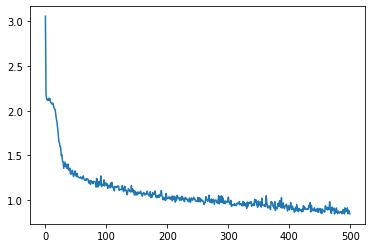

In [21]:
# 学習
loss_log = []
for e in range(EPOCH_NUM):
    total_loss = 0
    for x, y in train_loader:
        x, y = Variable(x), Variable(y)
        optimizer.zero_grad()
        output = net(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    ave_loss = total_loss / BATCH_SIZE
    loss_log.append(ave_loss)

    if (e + 1) % 50 == 0:
        print('Epoch: %d | Avearage Loss: %d' % (e + 1, ave_loss))

plt.plot([i for i in range(len(loss_log))], loss_log)

In [0]:
test_x = Variable(test_x)

net.eval()
result = torch.max(net(test_x).data, 1)[1]

In [0]:
# Google ColabでSubmit用ファイル保存
submission = pd.DataFrame()
submission['PassengerId'] = passenger_id
submission['Survived'] = result.data.to('cpu').numpy()
submission.to_csv('titanic_submission.csv', index=False)